# Real-Time Feature Stream

Simulating the real-time controller behavior by stacking Raw signal and Feature outputs.

## 1. Setup

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path

# Add project root to sys.path
sys.path.append(str(Path("..").resolve()))

from src import visualization, data_loader, filters, features, config

# Apply Thesis LaTeX Style
# This returns True if LaTeX is available, False otherwise
use_tex = visualization.set_plot_style()

# --- Smart Label Helper ---
# If LaTeX is missing, \textbf{} would print literally. This prevents that.
def fmt(text):
    if use_tex:
        return fr"\textbf{{{text}}}"
    else:
        return text  # Visualization module handles font weight for non-latex

Style set. LaTeX: False


## 2. Configuration

In [2]:
# Timestamps where muscle activity changes (seconds)
CHANGE_TIMES = [
    5.186, 9.823, 14.06, 20.04, 24.76, 29.77, 
    34.711, 39.864, 44.773, 49.667, 54.67, 59.635
]

# Optimal Thresholds found during training
RMS_THRESH = 0.019674902851809905
VAR_THRESH = 0.0008461925878994986
WL_THRESH = 0.7998157907723765

# Fixed Window Size for this plot (100ms)
WINDOW_MS = 100

## 3. Load Data

In [3]:
DATA_FILE = "../data/labeled_data.csv"

# Load & Convert
df = data_loader.load_labeled_csv(DATA_FILE)
raw_signal = (df['RawValue'] / 1023.0 * 5.0).values
raw_signal_centered = raw_signal - np.mean(raw_signal)

# Filter (4th Order)
clean_signal = filters.apply_butterworth_sos(raw_signal_centered, order=4, fs=config.FS)

# Calculate Features
window_samples = int(WINDOW_MS * config.FS / 1000)
times = df['Time'].values
t_vis = times[window_samples - 1:]

y_rms = features.calculate_rms(clean_signal, window_samples)
y_var = features.calculate_var(clean_signal, window_samples)
y_wl = features.calculate_wl(clean_signal, window_samples)

print(f"Features Calculated: {len(y_rms)} windows")

Features Calculated: 40291 windows


## 4. Plotting

Saved [DRAFT]: ../results/drafts/features_with_labels_redlines.png


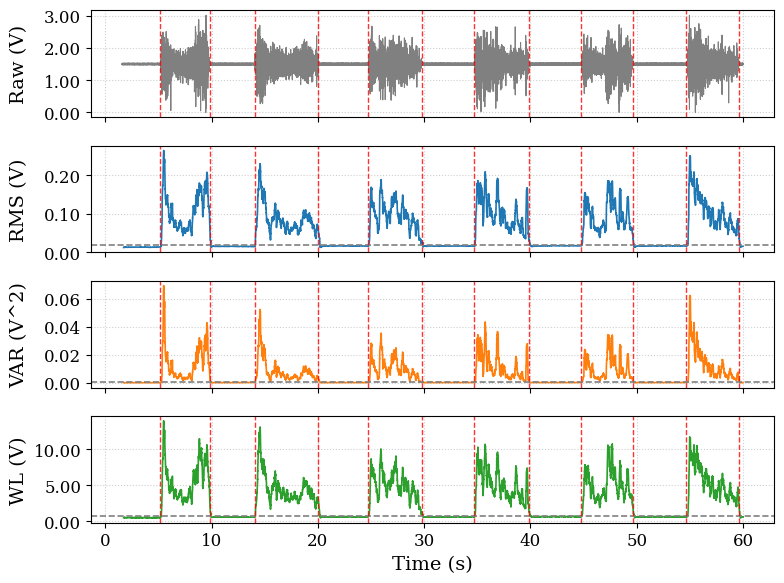

In [4]:
# Exact figsize from original script to match tick layout
fig, axs = plt.subplots(4, 1, figsize=(8.0, 6.0), sharex=True)

# 1. Raw Signal
axs[0].plot(times, raw_signal, color='gray', linewidth=0.8)
axs[0].set_yticks(list(range(0,4,1)))
axs[0].set_ylabel(fmt("Raw (V)"))

# 2. RMS
axs[1].plot(t_vis, y_rms, color=visualization.COLORS['RMS'], label='RMS')
axs[1].set_yticks([0, 0.1, 0.2])
axs[1].axhline(RMS_THRESH, color='gray', linestyle='--', label='Threshold')
axs[1].set_ylabel(fmt("RMS (V)"))

# 3. VAR
axs[2].plot(t_vis, y_var, color=visualization.COLORS['VAR'], label='VAR')
axs[2].set_yticks([0, 0.02, 0.04, 0.06])
axs[2].axhline(VAR_THRESH, color='gray', linestyle='--', label='Threshold')
axs[2].set_ylabel(fmt("VAR (V^2)")) # LaTeX will fix superscript automatically if enabled

# 4. WL
axs[3].plot(t_vis, y_wl, color=visualization.COLORS['WL'], label='WL')
axs[3].set_yticks([0, 5, 10])
axs[3].axhline(WL_THRESH, color='gray', linestyle='--', label='Threshold')
axs[3].set_ylabel(fmt("WL (V)"))
axs[3].set_xlabel(fmt("Time (s)"))

# --- Styling & Markers ---
for ax in axs:
    # Add Vertical Red Lines for Transitions
    for ct in CHANGE_TIMES:
        ax.axvline(x=ct, color='red', linestyle='--', linewidth=1, alpha=0.8)
    
    # Grid & Formatting
    ax.grid(True, linestyle=':', alpha=0.6)
    
    # Force 2 decimal places (Matches original script)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

fig.align_ylabels()
plt.tight_layout()

visualization.save_fig(fig, 'features_with_labels_redlines.png')
plt.show()